# My python code is too slow? What can I do?

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.data import astronaut
from scipy.ndimage import distance_transform_edt
from skimage import filters
%matplotlib inline

## Vectorization in plain python

First, let's look at vectorisation.
Vectorization in python / numpy means that significant parts of the code are executed in the native implementation 
(C for CPython). It can be employed by language specific constructs like list comprehensions in plain python and use of appropriate use of `[]` in numpy. 

In [2]:
# multiply 1 million numbers by 2 and append to list, naive implementation
N = int(1e6)

t = time.time()
x = []
for i in range(N):
    x.append(i*2)
t = time.time() - t
print('for-loop takes:')
print(t, 's')

for-loop takes:
0.12906312942504883 s


In [3]:
# same as above, but using a list comprehension
t = time.time()
x = [i*2 for i in range(N)]
t = time.time() - t
print('list comprehension takes:')
print(t, 's')

list comprehension takes:
0.07419443130493164 s


## Vectorization in numpy

In [4]:
# same as for loop above, but with numpy array
t = time.time()
x = np.zeros(N, dtype='uint64')
for i in range(N):
    x[i] = i*2
t = time.time() - t
print('numpy: for loop takes')
print(t, 's')

numpy: for loop takes
0.16148948669433594 s


In [5]:
# same as above but vectorized
t = time.time()
x = 2 * np.arange(N, dtype='uint64')
t = time.time() - t
print('numpy: vectorization takes')
print(t, 's')

numpy: vectorization takes
0.010403633117675781 s


In [ ]:
# TODO more complex numpy example

## Beyond vectorization

Vectorization is great! We can write python code and get (nearly) C speed. Unfortunately, it's not always possible and has other drawbacks:
- vectorizing complex functions can be hard
- or even impossible if a lot of `if` `else` statements are involved.
- for plain python, vectorization does not lift the GIL

Let's turn to a simple example, connected compoents of a binary image and pretend we don't know about `scipy.ndimage.label`.

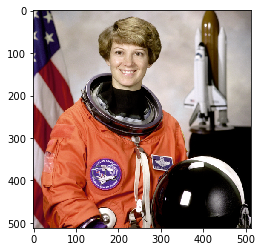

In [6]:
# load example data from skimage
data = astronaut()
plt.imshow(data)

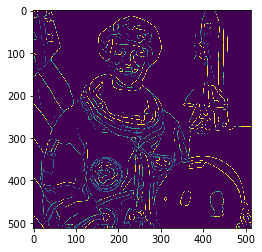

In [7]:
# make edge map using mean canny edge detector response of the three color channels
edges = np.array([feature.canny(data[..., i] / 255., sigma=3) 
                  for i in range(data.shape[-1])])
edges = np.mean(edges, axis=0)
plt.imshow(edges)

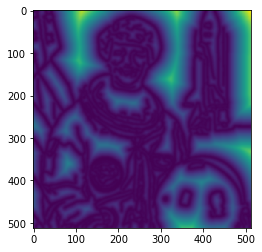

In [8]:
# compute and smooth distances to edges to get a better input map
distances = distance_transform_edt(edges < .25)
distances = filters.gaussian(distances, 2)
plt.imshow(distances)

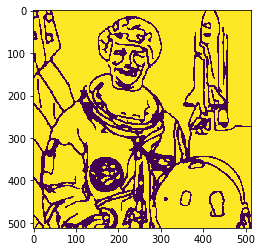

In [9]:
# compute the binary image we wany to use as input to connected components
binary_image = distances > 2
plt.imshow(binary_image)

Hooray, we have our input image. What do we do now? Remember, we don't know about `scipy.ndimage.label`.
So we will need to implement our own connected_components function in python.
Have a look at `ccpy/connected_components.py` for the implementation.

7.759756326675415 s


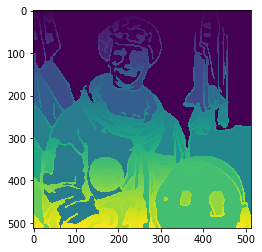

In [10]:
from ccpy import connected_components as py_components
t = time.time()
cc_py = py_components(binary_image)
t = time.time() - t
print(t, 's')
plt.imshow(cc_py)

This looks like the result we would expect, but it takes awfully long to compute the components!
What can we do to speed this up?
- Option 1: [numba](http://numba.pydata.org/): just in time compiler for numpy
- Option 2: [cython](https://cython.org/): write python / c (c++) hybrid code that gets compled to c (c++)
- Option 3: write your own c or c++ library and wrap it to python

## Numba

Numba is a just in time compiler for python that works well with numeric (numpy-based) code. It is very easy to use 
via the decorator `numba.jit`.

In [15]:
from numba import jit
# naive example from above

# nopython allows numba to optimize more,
# but it does not work in all cases, e.g. if python memory is allocated
# @jit(nopython=True)

# without nopython, numba works in 'object-mode' which works for more cases
# not as fast
@jit(nopython=True)
def go_fast():
    x = np.zeros(N, dtype='uint64')
    for i in range(N):
        x[i] = i*2

# same as for loop above, but with numpy array
t = time.time()
go_fast()
t = time.time() - t
print('numba: for loop takes')
print(t, 's')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (Literal[int](1000000), dtype=Literal[str](uint64))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at <ipython-input-15-fba3a2d3c8b6> (12)


File "<ipython-input-15-fba3a2d3c8b6>", line 12:
def go_fast():
    x = np.zeros(N, dtype='uint64')
    ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [16]:
# let's try to naively add numba to our watershed code ...
from ccnu import connected_components as nu_components
t = time.time()
cc_nu = nu_components(binary_image)
t = time.time() - t
print(t, 's')
plt.imshow(cc_py)

AssertionError: Failed in object mode pipeline (step: object mode frontend)


## Cython

In [ ]:
# TODO if time allows

## Custom C / C++

There are multiple ways to expose C / C++ code to python. Here, we will use an approach for modern C++, using [pybind11](https://github.com/pybind/pybind11) to build the python bindings and [xtensor](https://github.com/QuantStack/xtensor) / [xtensor-python](https://github.com/QuantStack/xtensor-python) for multi dimensional arrays in C++ and 
numpy buffers. See `ccxt/src/main.cpp`. For this example, I used a nice [cookiecutter set-up](https://github.com/QuantStack/xtensor-python-cookiecutter).

1.1517205238342285 s


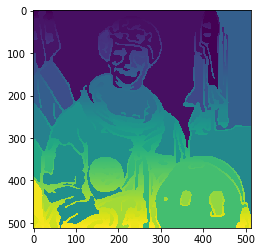

In [17]:
from ccxt import connected_components as cpplabel
t = time.time()
cc_cpp = cpplabel(binary_image)
t = time.time() - t
print(t, 's')
plt.imshow(cc_cpp)

0.004446268081665039 s


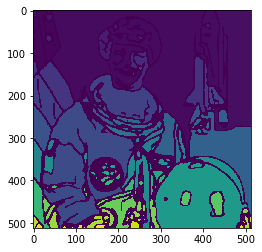

In [18]:
# just for fun lets see how we do compared to scipy
from scipy.ndimage import label
t = time.time()
cc_scipy, _ = label(binary_image)
t = time.time() - t
print(t, 's')
plt.imshow(cc_scipy)

## Summary

There are different ways to speed up python if it's necessary.
Which one is most appropriate depends on your application.
- vectorize yor code: easy but not allways applicable 
- numba: relatively easy, but you still need to be aware of it's limitations
- cython: python / C hybrid code that is potentially easier to write (and compile) than pure C
- C / C++ + python wrapper: fast, flexible and can be wrapped to other languages. BUT you need to know C or C++. Compilation can be a huge pain.

## What about deep learning?

Pytorch has a [just-in-time compiler](https://pytorch.org/docs/stable/jit.html) similar to the numba option. It also offers a [C++ frontend](https://pytorch.org/cppdocs/frontend.html) that could potentially be used to implement performance critical parts of the code and wrap them to python, although it's more tailored to embedded devices.